# **Feature Engineering**

In [2]:
import os
import numpy as np
import pandas as pd
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
import cv2
import random
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
import xgboost as xgb

# Load the pre-trained VGG16 model (without the top classification layer)
model = VGG16(weights='imagenet', include_top=False)

# Updated feature extraction function
def extract_image_features(image_path):
    try:
        if not os.path.exists(image_path):
            return np.zeros((7 * 7 * 512,))  # Default array matching VGG16 output
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array,verbose=0)
        features_flattened = features.flatten()  # Ensure a consistent output shape
        
        return features_flattened
    except Exception as e:
        return np.zeros((7 * 7 * 512,))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
# Define dataset directory
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")

dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"

# Feature extraction for Left-Fundus and Right-Fundus
df['Left-Fundus Features'] = df['Left-Fundus'].apply(
    lambda x: extract_image_features(os.path.join(dataset_dir, x))
)
df['Right-Fundus Features'] = df['Right-Fundus'].apply(
    lambda x: extract_image_features(os.path.join(dataset_dir, x))
)

print("Working....")

# Convert features into numpy arrays
left_features = np.array(df['Left-Fundus Features'].to_list())
right_features = np.array(df['Right-Fundus Features'].to_list())

I0000 00:00:1733953895.922091      69 service.cc:145] XLA service 0x7dab300043f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733953895.922155      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733953897.774679      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Working....


In [4]:
# Apply PCA
pca = PCA(n_components=50)
left_fundus_pca = pca.fit_transform(left_features)
right_fundus_pca = pca.fit_transform(right_features)

# Add PCA features back to the DataFrame
df['Left-Fundus PCA'] = list(left_fundus_pca)
df['Right-Fundus PCA'] = list(right_fundus_pca)

# Drop the original feature columns
df_final = df.drop(['Left-Fundus', 'Right-Fundus', 'Left-Fundus Features', 'Right-Fundus Features'], axis=1)

print(df_final.head())

   ID  Patient Age Patient Sex  \
0   0           69      Female   
1   1           57        Male   
2   2           42        Male   
3   4           53        Male   
4   5           50      Female   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0   

                                           

In [5]:
# Check column names in the DataFrame
print(df.columns)


Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename',
       'Left-Fundus Features', 'Right-Fundus Features', 'Left-Fundus PCA',
       'Right-Fundus PCA'],
      dtype='object')


In [6]:
# Check for missing values in 'Patient Age'
print(df['Patient Age'].isnull().sum())


0


In [7]:
# Define age groups
bins = [0, 20, 40, 60, 100]  # Define the age groups
labels = ['0-20', '21-40', '41-60', '61+']
df['Age Group'] = pd.cut(df['Patient Age'], bins=bins, labels=labels)

# Encode 'Patient Sex' column (assuming 'Male' = 0, 'Female' = 1)
df['Gender'] = df['Patient Sex'].map({'Male': 0, 'Female': 1})

# Check for missing values in 'Patient Age'
print(df['Patient Age'].isnull().sum())

# Fill missing values with the mean of 'Patient Age'
df['Patient Age'].fillna(df['Patient Age'].mean(), inplace=True)

# Define age groups
bins = [0, 20, 40, 60, 100]  # Define the age groups
labels = ['0-20', '21-40', '41-60', '61+']
df['Age Group'] = pd.cut(df['Patient Age'], bins=bins, labels=labels)

# Encode 'Patient Sex' column (assuming 'Male' = 0, 'Female' = 1)
df['Gender'] = df['Patient Sex'].map({'Male': 0, 'Female': 1})

0


/tmp/ipykernel_23/1681418561.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Patient Age'].fillna(df['Patient Age'].mean(), inplace=True)


In [8]:
# Check the distribution of 'Age Group' and 'Gender' in relation to the 'target' (pathological_myopia diagnosis)
pathological_myopia_by_age_gender = df.groupby(['Age Group', 'Gender'])['target'].value_counts().unstack().fillna(0)

# Print the result
print(pathological_myopia_by_age_gender)

target            [0, 0, 0, 0, 0, 0, 0, 1]  [0, 0, 0, 0, 0, 0, 1, 0]  \
Age Group Gender                                                       
0-20      0                              0                         0   
          1                              0                        24   
21-40     0                             23                         2   
          1                             11                         7   
41-60     0                            185                        35   
          1                            134                        53   
61+       0                            144                        38   
          1                            211                        73   

target            [0, 0, 0, 0, 0, 1, 0, 0]  [0, 0, 0, 0, 1, 0, 0, 0]  \
Age Group Gender                                                       
0-20      0                              0                         0   
          1                              0                     

/tmp/ipykernel_23/3955651283.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pathological_myopia_by_age_gender = df.groupby(['Age Group', 'Gender'])['target'].value_counts().unstack().fillna(0)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


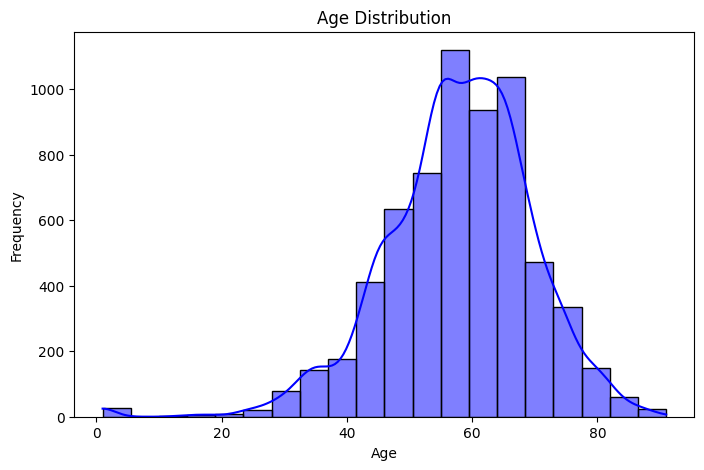

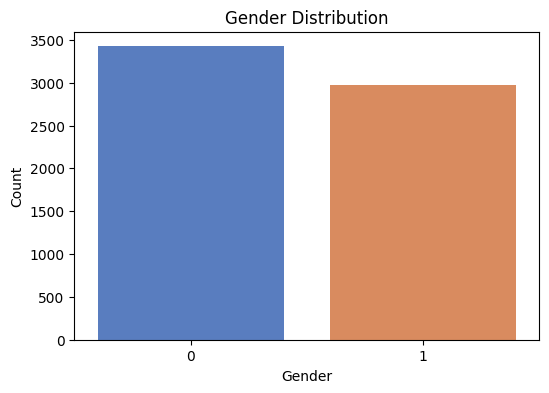

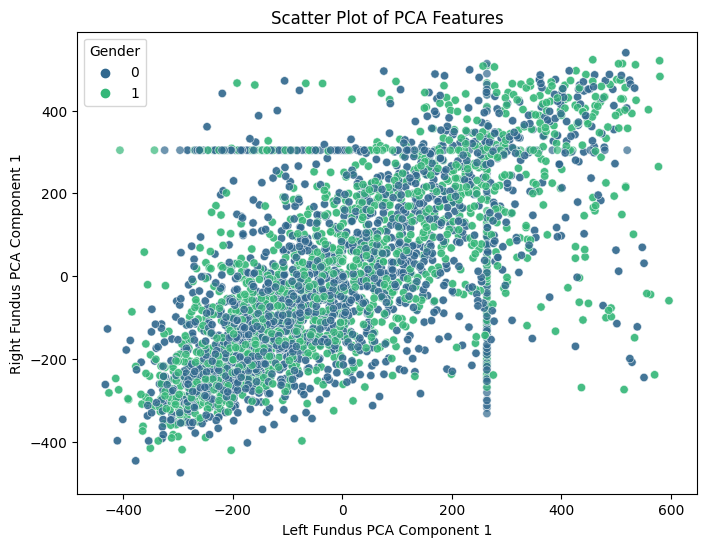

In [9]:
# Plotting age and gender distributions
# Example dataset assumption: 'Age' and 'Gender' columns exist
plt.figure(figsize=(8, 5))
sns.histplot(df_final['Patient Age'], bins=20, kde=True, color='blue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Gender distribution
df_final['Gender'] = df_final['Patient Sex'].map({'Male': 0, 'Female': 1})
gender_counts = df_final['Gender'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="muted")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# Scatter plot of PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_final['Left-Fundus PCA'].apply(lambda x: x[0]),
    y=df_final['Right-Fundus PCA'].apply(lambda x: x[0]),
    hue=df_final['Gender'], palette="viridis", alpha=0.7
)
plt.title("Scatter Plot of PCA Features")
plt.xlabel("Left Fundus PCA Component 1")
plt.ylabel("Right Fundus PCA Component 1")
plt.show()

   ID  Patient Age Patient Sex  \
0   0           69      Female   
1   1           57        Male   
2   2           42        Male   
3   4           53        Male   
4   5           50      Female   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  ...  M  O  \
0                           normal fundus  0  0  0  1  0  ...  0  0   
1                           normal fundus  1  0  0  0  0  ...  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  ...  0  1   
3       mild nonproliferative retinopathy  0  1  0  0  0  ...  0  1   
4  moderate non proliferative retinopathy  0  1  0  0  0  ...  0  0   

                               

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


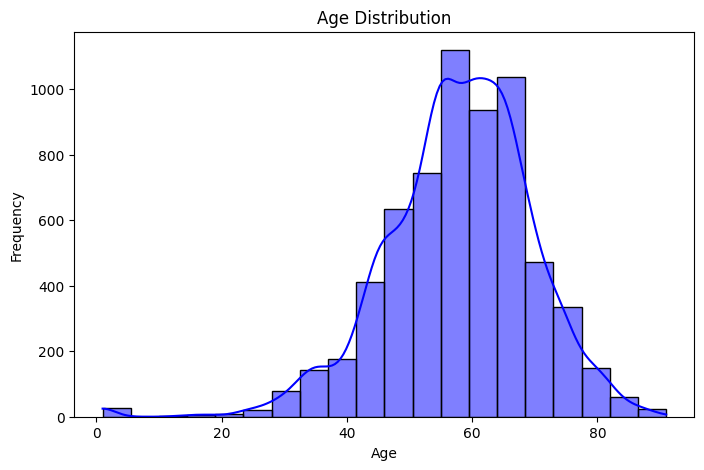

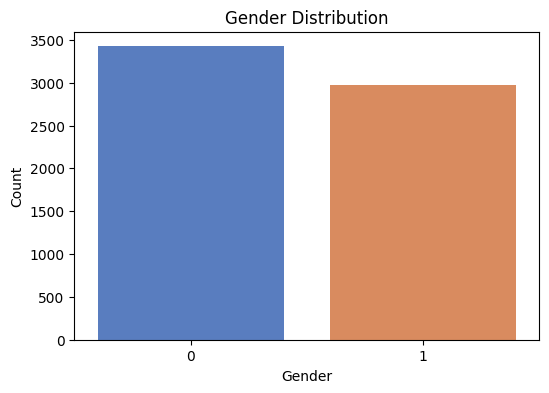

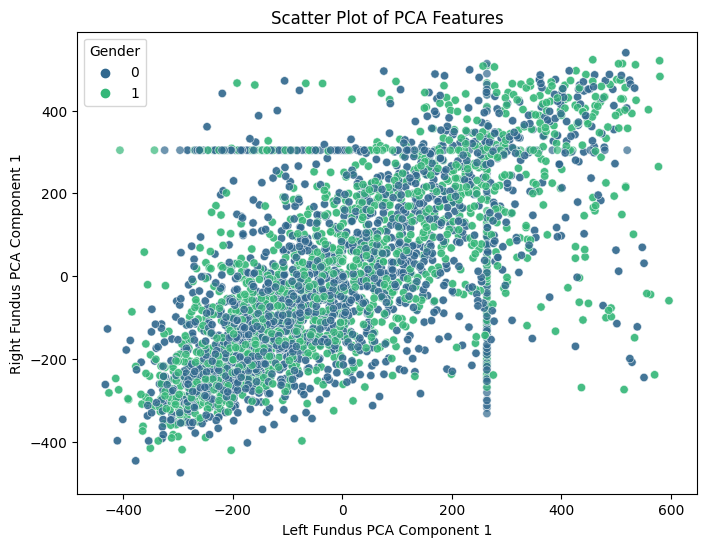

In [10]:
# Apply PCA
pca = PCA(n_components=50)
left_fundus_pca = pca.fit_transform(left_features)
right_fundus_pca = pca.fit_transform(right_features)

# Add PCA features back to the DataFrame
df['Left-Fundus PCA'] = list(left_fundus_pca)
df['Right-Fundus PCA'] = list(right_fundus_pca)

# Drop the original feature columns
df_final = df.drop(['Left-Fundus', 'Right-Fundus', 'Left-Fundus Features', 'Right-Fundus Features'], axis=1)

print(df_final.head())

# Plotting age and gender distributions
# Example dataset assumption: 'Age' and 'Gender' columns exist
plt.figure(figsize=(8, 5))
sns.histplot(df_final['Patient Age'], bins=20, kde=True, color='blue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Gender distribution
gender_counts = df_final['Gender'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="muted")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# Scatter plot of PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_final['Left-Fundus PCA'].apply(lambda x: x[0]), 
    y=df_final['Right-Fundus PCA'].apply(lambda x: x[0]),
    hue=df_final['Gender'], palette="viridis", alpha=0.7
)
plt.title("Scatter Plot of PCA Features")
plt.xlabel("Left Fundus PCA Component 1")
plt.ylabel("Right Fundus PCA Component 1")
plt.show()

# **Classification**

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
         # print(os.path.join(dirname, filename))
        os.path.join(dirname, filename)

In [12]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [13]:
def has_pathological_myopia(text):
    if "pathological myopia" in text:
        return 1
    else:
        return 0

In [14]:
df["left_pathological_myopia"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_pathological_myopia(x))
df["right_pathological_myopia"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_pathological_myopia(x))

In [28]:
df["left_pathological_myopia"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_pathological_myopia(x))
df["right_pathological_myopia"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_pathological_myopia(x))

left_pathological_myopia = df.loc[(df.M ==1) & (df.left_pathological_myopia == 1)]["Left-Fundus"].values
left_pathological_myopia[:15]

right_pathological_myopia = df.loc[(df.M ==1) & (df.right_pathological_myopia == 1)]["Right-Fundus"].values
right_pathological_myopia[:15]

print("Number of images in left pathological_myopia: {}".format(len(left_pathological_myopia)))
print("Number of images in right pathological_myopia: {}".format(len(right_pathological_myopia)))

left_normal = df.loc[(df.M ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.M ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

Number of images in left pathological_myopia: 216
Number of images in right pathological_myopia: 241


array(['2858_right.jpg', '2410_right.jpg', '893_right.jpg',
       '2602_right.jpg', '1142_right.jpg', '919_right.jpg',
       '3182_right.jpg', '2504_right.jpg', '2632_right.jpg',
       '2899_right.jpg', '4182_right.jpg', '3335_right.jpg',
       '3408_right.jpg', '3094_right.jpg', '3066_right.jpg'], dtype=object)

In [29]:
pathological_myopia = np.concatenate((left_pathological_myopia,right_pathological_myopia),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)
print(len(pathological_myopia),len(normal))

457 500


In [30]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

dataset = create_dataset(pathological_myopia,1)

len(dataset)

dataset = create_dataset(normal,0)

len(dataset)

100%|██████████| 500/500 [00:01<00:00, 378.20it/s]


954

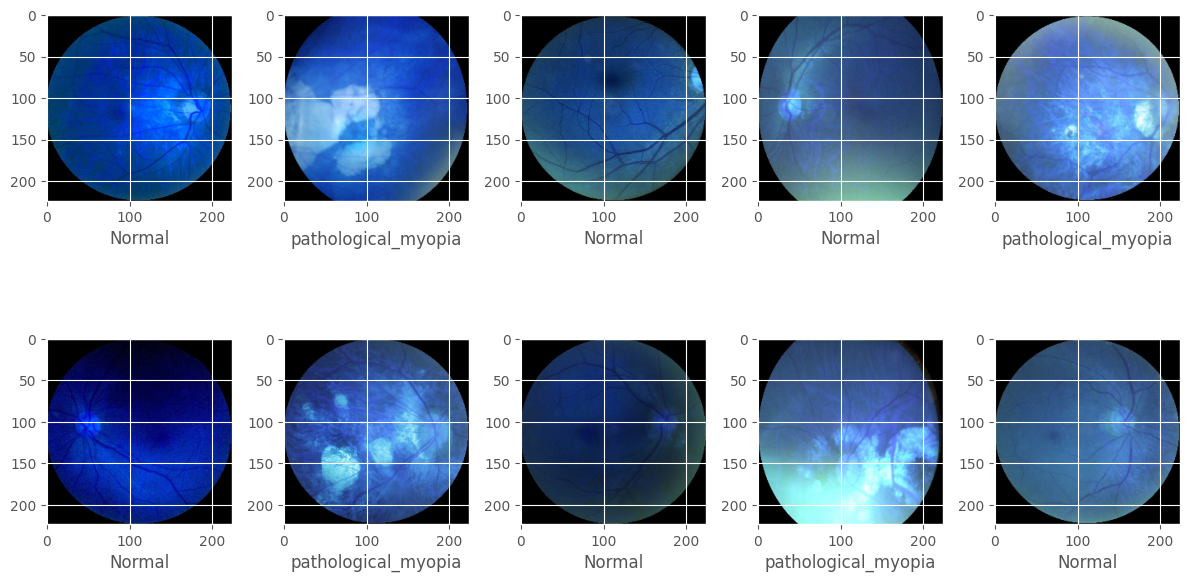

In [31]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "pathological_myopia"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [34]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

from tensorflow.keras.applications.vgg19 import VGG19
# vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))
vgg = VGG19(weights='/kaggle/input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top = False,input_shape=(image_size,image_size,3))

for layer in vgg.layers:
    layer.trainable = False

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

model.summary()

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.keras",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,save_freq='epoch', mode='max')
earlystop = EarlyStopping( monitor="val_accuracy",patience=5,verbose=1)

history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6904 - loss: 3.9698
Epoch 1: val_accuracy improved from -inf to 0.93194, saving model to vgg19.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.6962 - loss: 3.8980 - val_accuracy: 0.9319 - val_loss: 0.9189
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9718 - loss: 0.3491
Epoch 2: val_accuracy improved from 0.93194 to 0.98429, saving model to vgg19.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9721 - loss: 0.3435 - val_accuracy: 0.9843 - val_loss: 0.0518
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9900 - loss: 0.0472
Epoch 3: val_accuracy did not improve from 0.98429
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9901 - loss: 0.0471 - val_accuracy: 0.9738 - val_loss: 0.1575
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9944 - loss: 0.0521
Epoch 4: val_accuracy improved from 0.98429 to 0.98953, saving model to vgg19.keras
24/24 ━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
Accuracy: 0.9895287958115183
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       102
           1       0.98      1.00      0.99        89

    accuracy                           0.99       191
   macro avg       0.99      0.99      0.99       191
weighted avg       0.99      0.99      0.99       191



(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

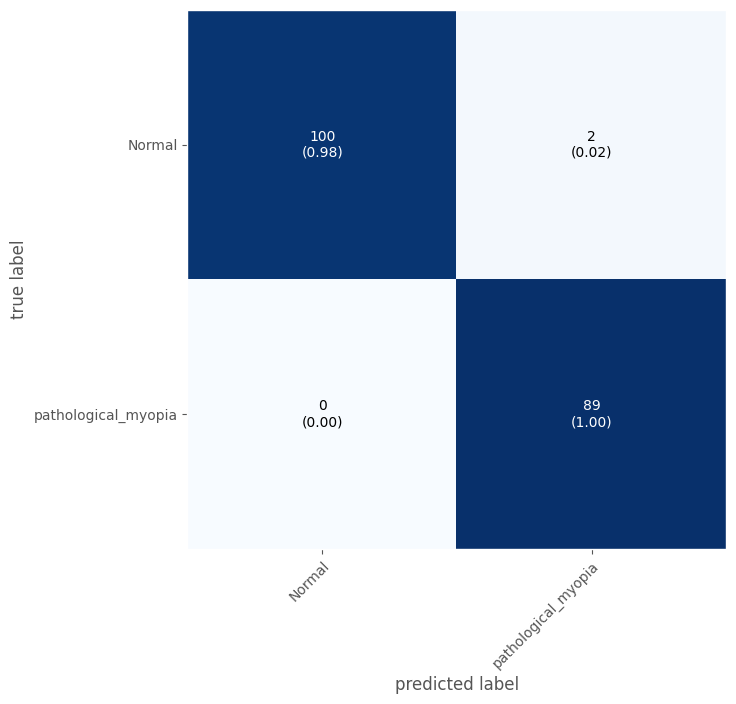

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# Get predicted probabilities
y_pred_probs = model.predict(x_test)

# Convert probabilities to class labels
# If it's binary classification
y_pred = (y_pred_probs > 0.5).astype("int32")

# If it's multi-class classification, use np.argmax
# y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report
print(classification_report(y_test, y_pred))

# Confusion matrix plot
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=cm, figsize=(8,7), class_names=["Normal", "pathological_myopia"], show_normed=True)

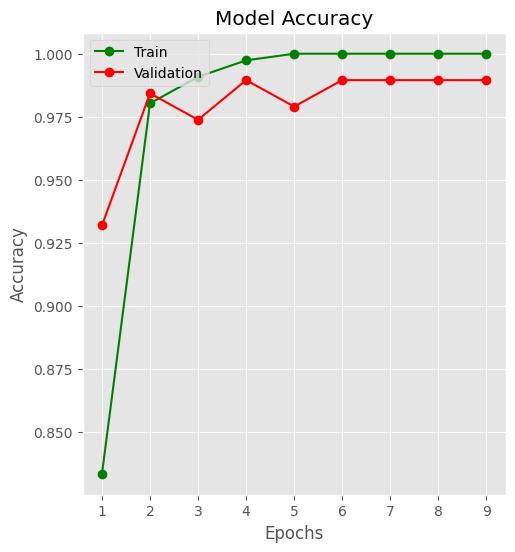

In [36]:
import matplotlib.pyplot as plt

# Set style
plt.style.use("ggplot")

# Create figure
fig = plt.figure(figsize=(12, 6))

# Get number of epochs from the training history
epochs = range(1, len(history.history["accuracy"]) + 1)

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")

plt.show()

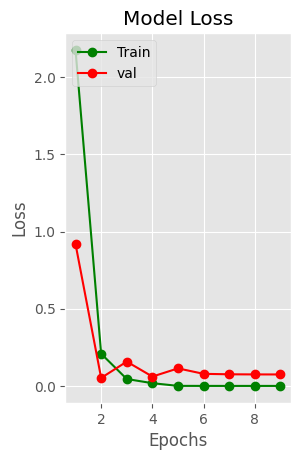

In [37]:
plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

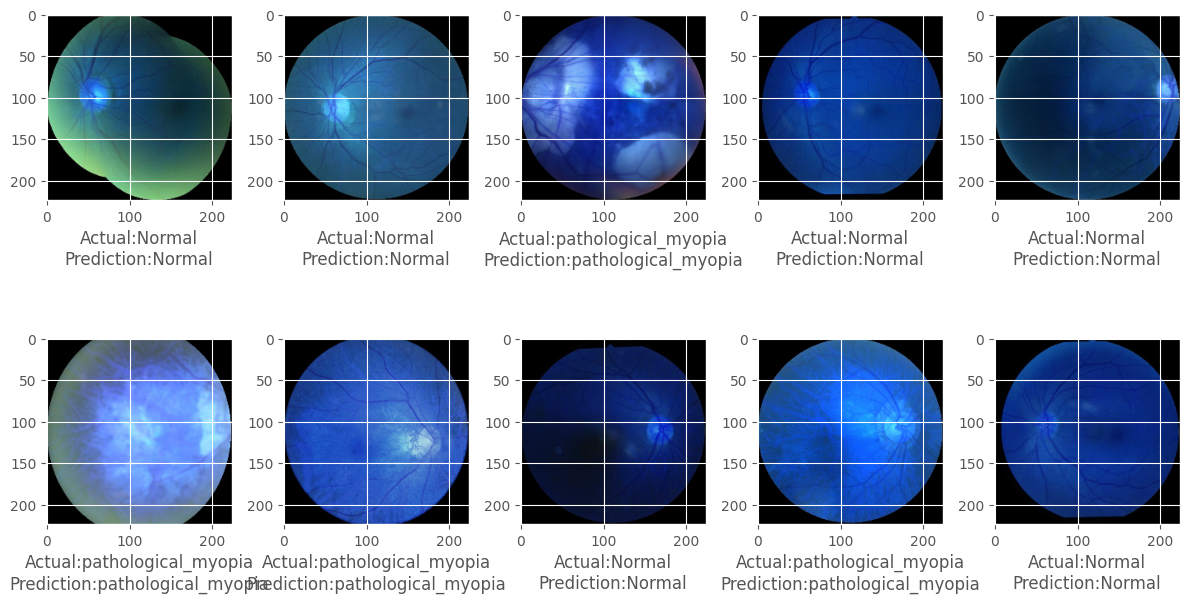

In [38]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "pathological_myopia"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "pathological_myopia"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

In [39]:
print("Number of images in left pathological_myopia: {}".format(len(left_pathological_myopia)))
print("Number of images in right pathological_myopia: {}".format(len(right_pathological_myopia)))

Number of images in left pathological_myopia: 216
Number of images in right pathological_myopia: 241


In [40]:
# Preprocessing steps (image loading and dataset creation as in previous code)

# Load dataset CSV
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")

# Apply the function to detect pathological_myopia in both eyes
df["left_pathological_myopia"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_pathological_myopia(x))
df["right_pathological_myopia"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_pathological_myopia(x))

# Separate images with pathological_myopia and normal images
left_pathological_myopia = df.loc[(df.M == 1) & (df.left_pathological_myopia == 1)]["Left-Fundus"].values
right_pathological_myopia = df.loc[(df.M == 1) & (df.right_pathological_myopia == 1)]["Right-Fundus"].values
left_normal = df.loc[(df.M == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250, random_state=42).values
right_normal = df.loc[(df.M == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250, random_state=42).values

# Concatenate left and right images
pathological_myopia = np.concatenate((left_pathological_myopia, right_pathological_myopia), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)

# Image size and dataset directory
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size = 224
dataset = []

# Function to create dataset
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
            dataset.append([np.array(image), np.array(label)])
        except:
            continue
    random.shuffle(dataset)
    return dataset

# Prepare dataset with labels
dataset = create_dataset(pathological_myopia, 1)
dataset = create_dataset(normal, 0)

# Separate images and labels
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

# Flatten image arrays for classical ML algorithms
x_flattened = x.reshape(x.shape[0], -1)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_flattened, y, test_size=0.2, random_state=42)

# Define classifiers to be used
classifiers = {
    "SVM": SVC(kernel='linear', probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "CatBoost": CatBoostClassifier(iterations=100, learning_rate=0.05, depth=5, verbose=0),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5)
}

# Dictionary to store metrics
metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

100%|██████████| 500/500 [00:01<00:00, 365.26it/s]



Training SVM...
SVM Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       113
           1       0.89      0.90      0.89        78

    accuracy                           0.91       191
   macro avg       0.91      0.91      0.91       191
weighted avg       0.91      0.91      0.91       191



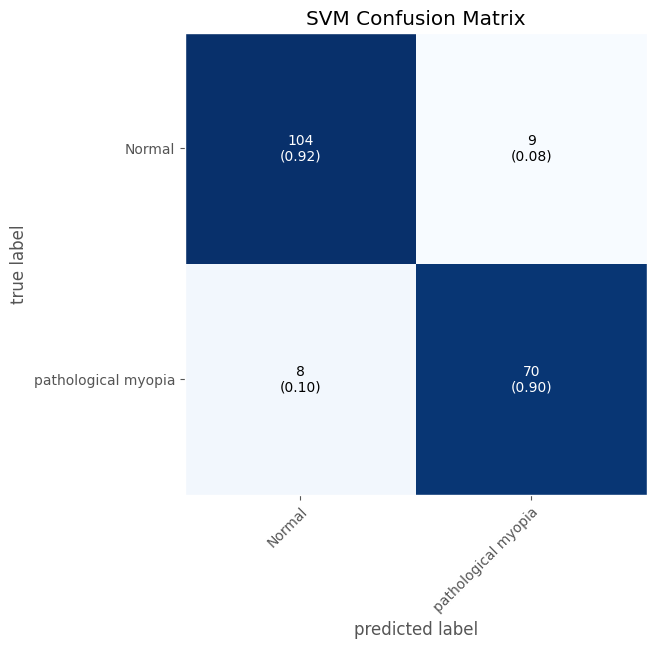


Training Decision Tree...
Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.81      0.86       113
           1       0.76      0.91      0.83        78

    accuracy                           0.85       191
   macro avg       0.85      0.86      0.85       191
weighted avg       0.86      0.85      0.85       191



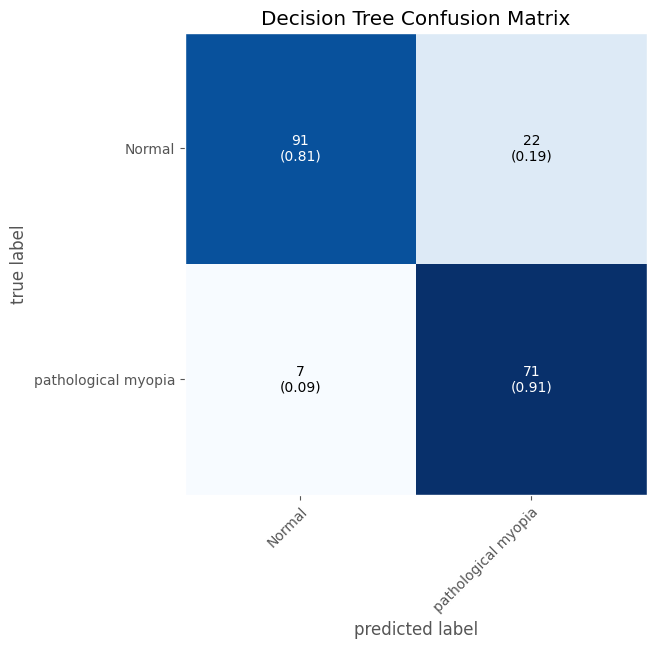


Training Naive Bayes...
Naive Bayes Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.70      0.73       113
           1       0.61      0.68      0.64        78

    accuracy                           0.69       191
   macro avg       0.68      0.69      0.69       191
weighted avg       0.70      0.69      0.69       191



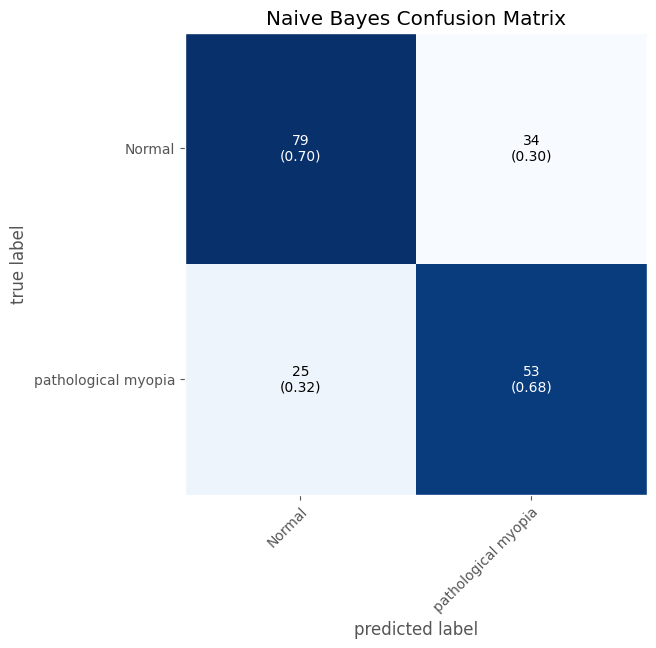


Training CatBoost...
CatBoost Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       113
           1       0.89      0.95      0.92        78

    accuracy                           0.93       191
   macro avg       0.93      0.93      0.93       191
weighted avg       0.93      0.93      0.93       191



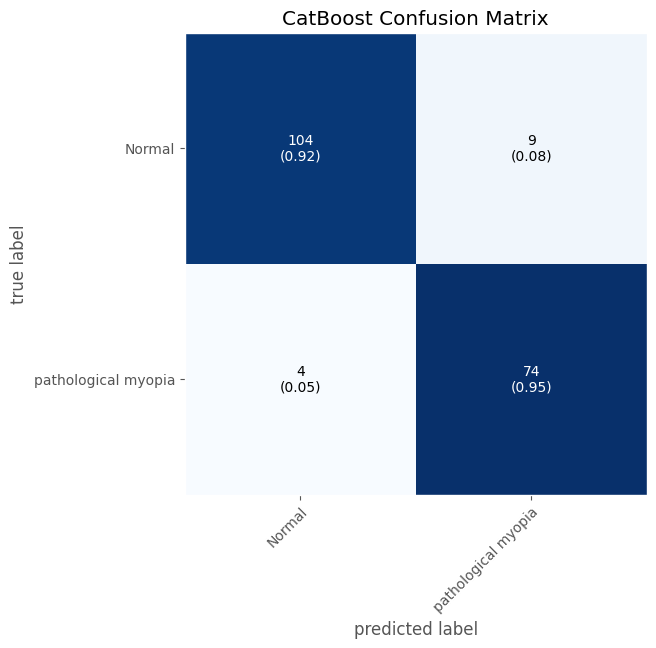


Training XGBoost...
XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       113
           1       0.87      0.94      0.90        78

    accuracy                           0.92       191
   macro avg       0.91      0.92      0.91       191
weighted avg       0.92      0.92      0.92       191



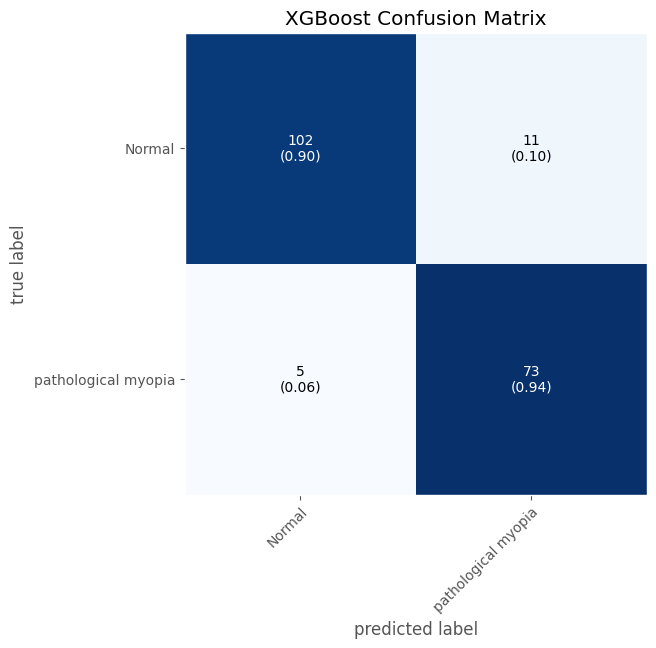

In [41]:
# Train, predict, and evaluate each model
for model_name, model in classifiers.items():
    print(f"\nTraining {model_name}...")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Append metrics
    metrics["Model"].append(model_name)
    metrics["Accuracy"].append(accuracy)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1-Score"].append(f1)
    
    # Display classification report
    print(f"{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), class_names=["Normal", "pathological myopia"], show_normed=True)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()


Comparative Analysis of Models:

           Model  Accuracy  Precision    Recall  F1-Score
0            SVM  0.910995   0.886076  0.897436  0.891720
1  Decision Tree  0.848168   0.763441  0.910256  0.830409
2    Naive Bayes  0.691099   0.609195  0.679487  0.642424
3       CatBoost  0.931937   0.891566  0.948718  0.919255
4        XGBoost  0.916230   0.869048  0.935897  0.901235


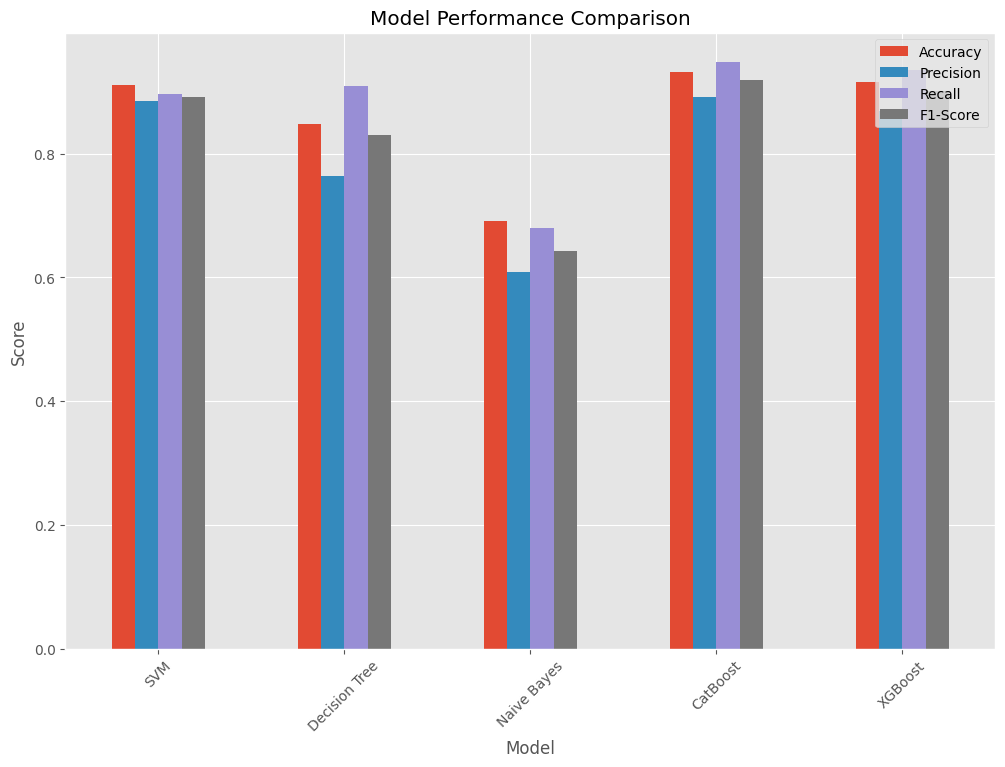

In [42]:
# Convert metrics to DataFrame for comparison
metrics_df = pd.DataFrame(metrics)
print("\nComparative Analysis of Models:\n")
print(metrics_df)

# Plotting the comparative metrics
metrics_df.set_index("Model", inplace=True)
metrics_df.plot(kind="bar", figsize=(12, 8))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()